# Pneumonia Detection from X-Ray images

## Introduction

- *Objective*: Detect pneumonia from X-Ray images using Machine Learning
- *Datasets*: Train, Validation and Test sets of JPEG images

The objective of this project is to develop a Machine Learning model to detect pneumonia from X-Ray images.

We will use these 3 datasets: Train, Validation and Test. 

Each containing JPEG images categorized as either normal or pneumonia-affected. 

The following steps outline our approach to achieve this goal.

# Steps

1. Data Loading and Exploration
2. Data Preprocessing
3. Feature Extraction
4. Model Training
5. Model Evaluation
6. Results and Visualization
7. Conclusion

# I. Data Loading & Exploration

### Import necessary libraries

In [51]:
import os
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

### Define the directories for the datasets

*(load datasets and explore its structure)*

In [52]:
# Define paths
base_dir = "../chest_Xray"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "val")

### Initialize ImageDataGenerator for data augmentation

(ImageDataGenerator is a class of Keras API for generating batches of image data with realtime data augmentation.)

Image preprocessing is the process of manipulating raw image data into a usable and meaningful format

It allows you to eliminate unwanted distortions and enhance specific qualities essential for computer vision applications

Preprocessing is a crucial first step to prepare image data before feeding it into machine learning models


Normalization: Adjust the intensity values of pixels to a desired range, often between 0 and 1. This can improve the performance of machine learning models.

*/train_datagen/*

**rescale**: rescale image pixel values from a range of [0, 255] to [0, 1]

common practice to normalize pixel values for neural network inputs to improve convergence

**flip**: flip image horizontally. Useful for augmenting image data because it creates new examples from existing images

====================================================================================

*/val_test_datagen/*

scale the pixel values from [0, 255] to [0, 1]. 

No other augmentations are applied to validation and test data because these datasets should represent the true distribution of the data

we want to evaluate our model on unaltered images.

In [53]:
# Initialize ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

**flow_from_directory** is a method provided by the ImageDataGenerator class to read images from a directory and generate batches of augmented data.

**target_size**: resize all images to 150x150 pixels

**batch_size**: return batches of 32 images

**class_mode='binary'**: classes are binary, two classes ('Pneumonia' and 'Normal')

In [54]:
# ImageDataGenerator for preprocessing (normalization)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [55]:
# Display class indices
print("train", train_generator.class_indices)
print("val", val_generator.class_indices)
print("test", test_generator.class_indices)

train {'NORMAL': 0, 'PNEUMONIA': 1}
val {'NORMAL': 0, 'PNEUMONIA': 1}
test {'NORMAL': 0, 'PNEUMONIA': 1}


# II. Data Preprocessing & Feature Extraction

**data**: initialized to hold flatterned images
**labels**: initialized to hold the corresponding labels

**num_samples**: total number of images
**num_features**: total number of features per image, calculated as the product of the image dimensions (e.g., 150 * 150 * 3 = 67500)

In [56]:
# Flatten the images into 1D arrays for simplicity
# Note: This is a basic method which might not catch the complexity effectively

def flatten_images(generator):
    num_samples = generator.samples
    num_features = np.prod(generator.image_shape)
    data = np.zeros((num_samples, num_features))
    labels = np.zeros((num_samples,))
    
    i = 0

    # iterates over the batches of images and labels provided by the generator
    # flattens each image in the batch to a 1D array of length 67500
    for inputs_batch, labels_batch in generator:
        # reshapes the batch of images from (batch_size, 150, 150, 3) to (batch_size, 67500)
        data[i * generator.batch_size : (i + 1) * generator.batch_size] = inputs_batch.reshape(inputs_batch.shape[0], -1)
        labels[i * generator.batch_size : (i + 1) * generator.batch_size] = labels_batch
        i += 1
        if i * generator.batch_size >= num_samples:
            break
    
    return data, labels

# flattened images and corresponding labels are stored in the initialized arrays.
train_data, train_labels = flatten_images(train_generator)
val_data, val_labels = flatten_images(val_generator)
test_data, test_labels = flatten_images(test_generator)

print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (5216, 67500)
Validation data shape: (16, 67500)
Test data shape: (624, 67500)


# Visualize Sample Images

A plot is a graphical representation of data. In the context of Matplotlib:
- Plots can display data in various forms such as line charts, bar charts, images, etc.

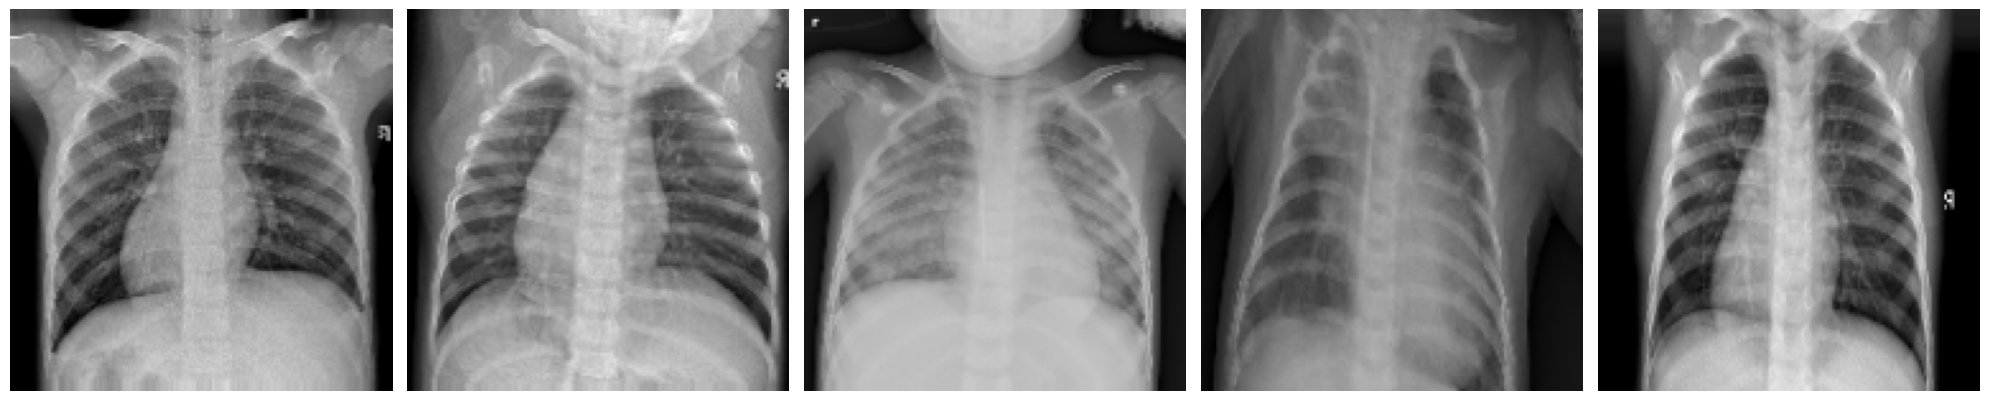

In [57]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Fetch a batch of images
sample_training_images, _ = next(train_generator)

# Plot the images
plot_images(sample_training_images[:5])

# Train the Random Forest Classifier

RandomForestClassifier from sklearn

In [58]:
# initialize the random forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# train the model
rf_clf.fit(train_data, train_labels)

Validation Accuracy: 0.6875
              precision    recall  f1-score   support

         0.0       1.00      0.38      0.55         8
         1.0       0.62      1.00      0.76         8

    accuracy                           0.69        16
   macro avg       0.81      0.69      0.65        16
weighted avg       0.81      0.69      0.65        16



# Validate the model using validation dataset

In [ ]:
# validate the model
val_predictions = rf_clf.predict(val_data)

print("Validation Accuracy:", accuracy_score(val_labels, val_predictions))
print(classification_report(val_labels, val_predictions))

# Model evaluation

Evaluate the model using test dataset

In [59]:
test_predictions = rf_clf.predict(test_data)

print("Test Accuracy:", accuracy_score(test_labels, test_predictions))
print(classification_report(test_labels, test_predictions))

Test Accuracy: 0.8413461538461539
              precision    recall  f1-score   support

         0.0       0.91      0.64      0.75       234
         1.0       0.82      0.96      0.88       390

    accuracy                           0.84       624
   macro avg       0.86      0.80      0.82       624
weighted avg       0.85      0.84      0.83       624



# Result and visualization

In [60]:
"""def visualize_predictions(test_data, test_labels, predictions, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i+1)
        image = test_data[i].reshape(150, 150)
        plt.imshow(image, cmap='gray')
        plt.title(f'Actual: {test_labels[i]}, Predicted: {predictions[i]}')
        plt.axis('off')
    plt.show()

visualize_predictions(test_data, test_labels, test_predictions)"""

"def visualize_predictions(test_data, test_labels, predictions, num_images=10):\n    plt.figure(figsize=(20, 10))\n    for i in range(num_images):\n        plt.subplot(2, 5, i+1)\n        image = test_data[i].reshape(150, 150)\n        plt.imshow(image, cmap='gray')\n        plt.title(f'Actual: {test_labels[i]}, Predicted: {predictions[i]}')\n        plt.axis('off')\n    plt.show()\n\nvisualize_predictions(test_data, test_labels, test_predictions)"